tensor(0.0204) tensor(0.5352)


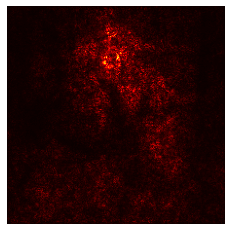

In [14]:
#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import cv2
#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Opening the image
img = Image.open('cat_dog.png')
# img = Image.open('input.jpg')

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the logit scores.
'''

logits = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
logits_max_index = logits.argmax()
logits_max = logits[0,logits_max_index]

'''
backward function on logits_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
logits_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency_map, _ = torch.max(X.grad.data.abs(),dim=1)
print (torch.mean(saliency_map),torch.max(saliency_map))

# code to plot the saliency map as a heatmap
plt.imshow(saliency_map[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

Most important feature map index:  652
Its corresponding importance is:  0.0042285775


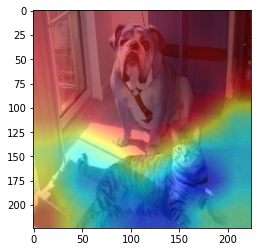

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import models


def process_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    p_img = img.copy()[:, :, ::-1]
    for i in range(3):
        p_img[:, :, i] = p_img[:, :, i] - means[i]
        p_img[:, :, i] = p_img[:, :, i] / stds[i]
    p_img = np.ascontiguousarray(np.transpose(p_img, (2, 0, 1)))
    p_img = torch.from_numpy(p_img)
    p_img.unsqueeze_(0)
    input = p_img.requires_grad_(True)
    return input

class Feat_Extractor():
    """ register gradients get activations from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class Netout():
    """ Get network output through forward pass and get intermediate layer representation
    and gradient computation for targeted intermediate layer  """

    def __init__(self, net, feat_module, target_layers):
        self.model = net
        self.feature_module = feat_module
        self.feature_extractor = Feat_Extractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
    
            else:
                x = module(x)
        
        return target_activations, x


#visualize heatmap on input image
def visualize(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img = np.uint8(255 * cam)
    filename = "gradcam_tigercat.png"
    cv2.imwrite(filename, img)
    plt.imshow(img)


class GradientCam:
    def __init__(self, model, feature_module, target_layer_, cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = Netout(self.model, self.feature_module, target_layer_)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        ''' This function should Return weights corresponding to each feature map of last convolution layer.
        Note that, linear combination of such weights with last conv layer feature map finally 
        produce the explanation map'''

        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        class_activation_map = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            class_activation_map += w * target[i, :, :]

        class_activation_map = np.maximum(class_activation_map, 0)
        class_activation_map = cv2.resize(class_activation_map, input.shape[2:])
        class_activation_map = class_activation_map - np.min(class_activation_map)
        class_activation_map = class_activation_map / np.max(class_activation_map)
        
        return weights, class_activation_map


if __name__ == '__main__':
    
    image = cv2.imread('cat_dog.png', 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    input = process_image(image)

    net = models.resnet50(pretrained=True)
    grad_cam = GradientCam(model=net, feature_module=net.layer4, \
                       target_layer_=["2"], cuda=False)
    

    target_index = 283

    ### call to grad_cam method should return the importance vector corresponds to
    ### each feature map of last convolution layer of pretrained Resnet50

    weights, class_activation_map = grad_cam(input, target_index)

    print ("Most important feature map index: ", np.argmax(weights))
    print ("Its corresponding importance is: ", np.max(weights))

    visualize(image, class_activation_map)